# Ray Tracing at City Scale

In [1]:
from pathlib import Path

import jax.numpy as jnp
import numpy as np

import differt.plotting as dplt
from differt.geometry import TriangleMesh
from differt.geometry.triangle_mesh import (
    triangles_contain_vertices_assuming_inside_same_plane,
)
from differt.rt.image_method import (
    consecutive_vertices_are_on_same_side_of_mirrors,
    image_method,
)
from differt.rt.utils import generate_all_path_candidates, rays_intersect_triangles

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


RFBOutputContext()

CanvasBackend(css_height='600px', css_width='800px')
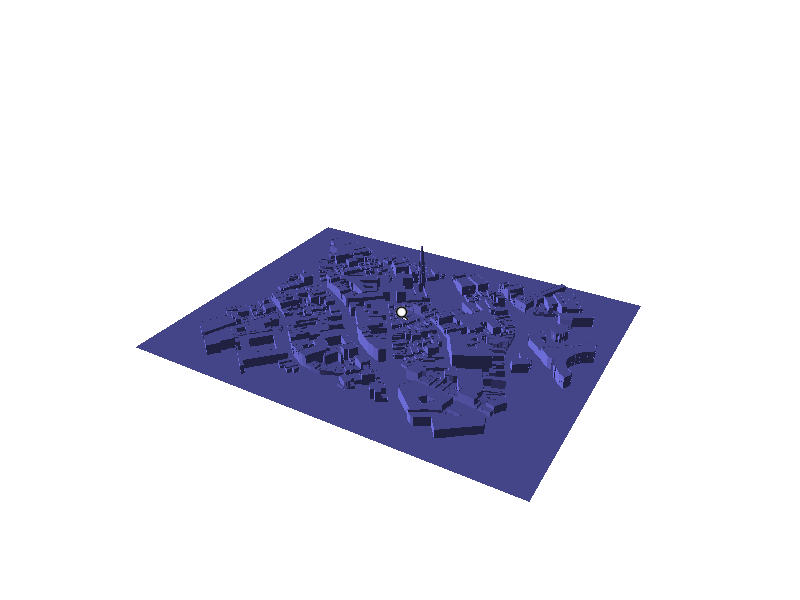

In [2]:
mesh_file = Path("bruxelles.obj")
mesh = TriangleMesh.load_obj(mesh_file)

canvas = mesh.plot()

tx = jnp.array([0.0, 4.9352, 22.0])
rx = jnp.array([0.0, 10.034, 1.50])

dplt.draw_markers(np.array([tx, rx]), ["tx", "rx"], canvas=canvas)

color = ["black", "green", "orange", "yellow"]

all_triangle_vertices = jnp.take(mesh.vertices, mesh.triangles, axis=0)

num_triangles = mesh.triangles.shape[0]

for order in range(0, 1):
    # Prepare input arrays
    path_candidates = generate_all_path_candidates(num_triangles, order)
    num_candidates = path_candidates.shape[1]
    from_vertices = jnp.tile(tx, (num_candidates, 1))
    to_vertices = jnp.tile(rx, (num_candidates, 1))
    triangles = jnp.take(mesh.triangles, path_candidates, axis=0)
    triangle_vertices = jnp.take(mesh.vertices, triangles, axis=0)
    mirror_vertices = triangle_vertices[
        ..., 0, :
    ]  # Only one vertex per triangle is needed
    mirror_normals = jnp.take(mesh.normals, path_candidates, axis=0)

    # Trace paths
    paths = image_method(from_vertices, to_vertices, mirror_vertices, mirror_normals)

    # Remove paths with vertices outside triangles
    mask = triangles_contain_vertices_assuming_inside_same_plane(
        triangle_vertices,
        paths,
    )
    mask = jnp.all(mask, axis=0)

    full_paths = jnp.concatenate(
        (
            jnp.expand_dims(from_vertices[mask, :], axis=0),
            paths[:, mask, :],
            jnp.expand_dims(to_vertices[mask, :], axis=0),
        )
    )

    # Remove paths with vertices not on the same side of mirrors
    mask = consecutive_vertices_are_on_same_side_of_mirrors(
        full_paths, mirror_vertices[:, mask, ...], mirror_normals[:, mask, ...]
    )

    mask = jnp.all(mask, axis=0)

    # [order+1 num_paths 3]
    ray_origins = full_paths[:-1, ...]
    ray_directions = jnp.diff(full_paths, axis=0)

    ray_origins = jnp.repeat(
        jnp.expand_dims(ray_origins, axis=-2), num_triangles, axis=-2
    )
    ray_directions = jnp.repeat(
        jnp.expand_dims(ray_directions, axis=-2), num_triangles, axis=-2
    )

    t, hit = rays_intersect_triangles(
        ray_origins,
        ray_directions,
        jnp.broadcast_to(all_triangle_vertices, (*ray_origins.shape, 3)),
    )
    intersect = (t < 0.999) & hit
    intersect = jnp.any(intersect, axis=(0, 2))
    mask = mask & ~intersect

    full_paths = full_paths[:, mask, ...]

    if order == 0:
        full_paths = jnp.concatenate(
            (
                tx[None, None, :],
                rx[None, None, :],
            )
        )

    full_paths = jnp.swapaxes(full_paths, 0, 1)

    dplt.draw_paths(full_paths, canvas=canvas)

canvas

In [4]:
mesh.triangles.shape

(14206, 3)